In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
from scipy import stats

import plotly.graph_objects as go
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import HDBSCAN
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, max_error, mean_absolute_percentage_error, mean_squared_error, accuracy_score, precision_score, recall_score

In [2]:
# Create a function that will add rolling window features to the dataset
def rolling_features(df, columns, window, agg_function):
    df = df.copy()
    for col in columns:
        col_name = f"rolling_{agg_function}_{window}_{col}"
        df[col_name] = df[col].rolling(window).agg(agg_function).bfill()
    return df

# Create a function that measures the correlation between a target columns and all other columns
def get_corr(features, targets):
    my_list = []
    for col in targets.columns:
        my_dict = {"column": col}
        for other_col in features.columns:
            p_corr = targets[col].corr(features[other_col])
            my_dict.update({other_col: p_corr})
        my_list.append(my_dict)
        df = pd.DataFrame(my_list)
    return df

# Create a function that returns outliers for any given numerical column
def locate_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + IQR * 1.5
    lower_bound = Q1 - IQR * 1.5
    upper_outliers = df.loc[df[col] > upper_bound]
    lower_outliers = df.loc[df[col] < lower_bound]
    return upper_bound, lower_bound, upper_outliers, lower_outliers

In [3]:
# Load the data and create a dataframe
path = "../data/clean/cleaned.csv"
df = pd.read_csv(path)
df.head()

,timestamp,distance,position_lat,position_long,altitude,speed,grade,vertical_speed,ascent,descent,power,heart_rate,cadence,temperature,latitude_deg,longitude_deg,distance_increment,time_increment,elevation_increment
0,2024-08-11 07:00:23,0.000000,729232816.0,124940754.0,267.6,0.000000,0.0,0.0,0.0,0.0,NaN,NaN,NaN,21.0,61.123589,10.472413,0.000000,0.0,0.0
1,2024-08-11 07:00:25,5.546657,729233408.0,124940880.0,267.6,2.773329,0.0,0.0,0.0,0.0,0.0,103.0,0.0,21.0,61.123638,10.472424,5.546657,2.0,0.0
2,2024-08-11 07:00:26,6.400561,729233499.0,124940902.0,267.6,0.853904,0.0,0.0,0.0,0.0,0.0,104.0,0.0,21.0,61.123646,10.472425,0.853904,1.0,0.0
3,2024-08-11 07:00:27,8.945471,729233772.0,124940891.0,267.6,2.544910,0.0,0.0,0.0,0.0,0.0,105.0,0.0,21.0,61.123669,10.472425,2.544910,1.0,0.0
4,2024-08-11 07:00:28,11.076667,729233999.0,124940834.0,267.6,2.131195,0.0,0.0,0.0,0.0,0.0,109.0,0.0,21.0,61.123688,10.472420,2.131195,1.0,0.0


In [4]:
# Check the data types
df.dtypes

timestamp               object
distance               float64
position_lat           float64
position_long          float64
altitude               float64
speed                  float64
grade                  float64
vertical_speed         float64
ascent                 float64
descent                float64
power                  float64
heart_rate             float64
cadence                float64
temperature            float64
latitude_deg           float64
longitude_deg          float64
distance_increment     float64
time_increment         float64
elevation_increment    float64
dtype: object

In [5]:
# Convert the timestamp from object to datetime
df.timestamp = pd.to_datetime(df.timestamp)

In [6]:
# Add the rolling window features to the dataset
df = rolling_features(df, columns=["speed", "grade", "vertical_speed"], window=10, agg_function="mean")
df = rolling_features(df, columns=["vertical_speed"], window=5, agg_function="mean")
df = rolling_features(df, columns=["elevation_increment"], window=10, agg_function="sum")

# Drop the rows where the rolling window function created null values
#df = df.dropna(subset="rolling_mean_10_speed").copy()

In [7]:
# Check the correlation between heart_rate and the other columns
targets = df[["heart_rate"]]
features = df.drop(columns=targets.columns)
correlation = get_corr(features, targets)

correlation_long = pd.melt(correlation, id_vars=['column'], var_name='variable', value_name='value')
correlation_long_sorted = correlation_long.sort_values(by=['column', 'value'], ascending=False).reset_index(drop=True)

correlation_long_sorted

,column,variable,value
0,heart_rate,power,0.601250
1,heart_rate,rolling_mean_10_vertical_speed,0.527457
2,heart_rate,rolling_mean_5_vertical_speed,0.518676
3,heart_rate,vertical_speed,0.510291
4,heart_rate,rolling_sum_10_elevation_increment,0.507437
5,heart_rate,descent,0.500720
6,heart_rate,longitude_deg,0.466632
7,heart_rate,position_long,0.466632
8,heart_rate,elevation_increment,0.439168
9,heart_rate,rolling_mean_10_grade,0.420437


In [8]:
df.corr()

,timestamp,distance,position_lat,position_long,altitude,speed,grade,vertical_speed,ascent,descent,...,latitude_deg,longitude_deg,distance_increment,time_increment,elevation_increment,rolling_mean_10_speed,rolling_mean_10_grade,rolling_mean_10_vertical_speed,rolling_mean_5_vertical_speed,rolling_sum_10_elevation_increment
timestamp,1.000000,0.998114,-0.729646,-0.507256,-0.012945,-0.099425,0.058116,-0.027884,0.996090,-0.996590,...,-0.729646,-0.507256,-0.030829,0.000212,-0.023232,-0.103427,0.059078,-0.028214,-0.027994,-0.026290
distance,0.998114,1.000000,-0.715786,-0.516169,-0.007694,-0.097911,0.052052,-0.033251,0.997913,-0.998091,...,-0.715786,-0.516169,-0.030166,-0.000099,-0.027899,-0.101775,0.052897,-0.033681,-0.033399,-0.031606
position_lat,-0.729646,-0.715786,1.000000,0.643386,-0.062643,0.074327,-0.068935,0.001871,-0.718060,0.714019,...,1.000000,0.643386,0.021062,-0.000189,-0.000102,0.077396,-0.070060,0.001878,0.001872,-0.000130
position_long,-0.507256,-0.516169,0.643386,1.000000,-0.112600,0.116909,-0.090232,0.002717,-0.496887,0.489856,...,0.643386,1.000000,0.035393,-0.001143,0.000274,0.121708,-0.091697,0.002740,0.002722,0.000281
altitude,-0.012945,-0.007694,-0.062643,-0.112600,1.000000,-0.053244,0.010178,0.007151,0.025793,0.035362,...,-0.062643,-0.112600,-0.015815,-0.003897,0.002668,-0.058575,0.013144,0.010839,0.008806,0.006813
speed,-0.099425,-0.097911,0.074327,0.116909,-0.053244,1.000000,-0.772638,-0.783141,-0.096520,0.093236,...,0.074327,0.116909,0.311761,-0.008774,-0.702598,0.953837,-0.767709,-0.767536,-0.776259,-0.779610
grade,0.058116,0.052052,-0.068935,-0.090232,0.010178,-0.772638,1.000000,0.779158,0.047058,-0.046422,...,-0.068935,-0.090232,-0.242524,-0.003659,0.680247,-0.803707,0.968257,0.761825,0.774666,0.783137
vertical_speed,-0.027884,-0.033251,0.001871,0.002717,0.007151,-0.783141,0.779158,1.000000,-0.035007,0.035434,...,0.001871,0.002717,-0.244454,0.000037,0.866889,-0.816409,0.758305,0.974896,0.993087,0.995999
ascent,0.996090,0.997913,-0.718060,-0.496887,0.025793,-0.096520,0.047058,-0.035007,1.000000,-0.998130,...,-0.718060,-0.496887,-0.029679,-0.000300,-0.029500,-0.100417,0.047911,-0.035380,-0.035127,-0.033338
descent,-0.996590,-0.998091,0.714019,0.489856,0.035362,0.093236,-0.046422,0.035434,-0.998130,1.000000,...,0.714019,0.489856,0.028703,0.000061,0.029655,0.096806,-0.047094,0.036033,0.035655,0.033745


## Predict heart_rate

The mean absolute error for the test set is: 1.1509094106984594
The max error for the test set is: 28.496192932128906
The mean absolute percentage error for the test set is: 0.010229104315364477
The r2 score is: 0.9989908364541199
The r2 score is: 0.9849931305750762


<Axes: >

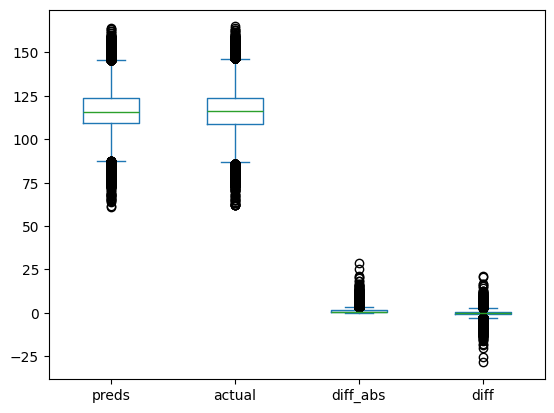

In [9]:

feature_cols = [
    'distance',
    'altitude',
    'temperature',
    'rolling_mean_10_speed',
    'rolling_mean_10_grade',
    'rolling_mean_10_vertical_speed',
    'rolling_sum_10_elevation_increment'
]

training_data = df.drop(columns="timestamp").dropna().copy()
target = training_data["heart_rate"]
features = training_data[feature_cols]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

heart_rate_poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
heart_rate_poly.fit(X_train)
X_train_int = heart_rate_poly.transform(X_train)
X_test_int = heart_rate_poly.transform(X_test)

heart_rate_scaler = StandardScaler()
heart_rate_scaler.fit(X_train_int)
X_train_scaled = heart_rate_scaler.transform(X_train_int)
X_test_scaled = heart_rate_scaler.transform(X_test_int)

heart_rate_xgb = XGBRegressor(
    learning_rate=0.1, # 0.2
    n_estimators=1600, # 1500
    max_depth=11, # 9
    subsample=0.5, # 0.5
    reg_lambda=20 # 10
)
heart_rate_xgb.fit(X_train_scaled, y_train)
pred = heart_rate_xgb.predict(X_test_scaled)

print(f"The mean absolute error for the test set is: {float(mean_absolute_error(y_test, pred))}")
print(f"The max error for the test set is: {float(max_error(y_test, pred))}")
print(f"The mean absolute percentage error for the test set is: {float(mean_absolute_percentage_error(y_test, pred))}")
print(f"The r2 score is: {heart_rate_xgb.score(X_train_scaled, y_train)}")
print(f"The r2 score is: {heart_rate_xgb.score(X_test_scaled, y_test)}")

pred_df = pd.DataFrame(pred, columns=["preds"], index=X_test.index)
pred_df["actual"] = y_test.values
pred_df["diff_abs"] = abs(pred_df.actual - pred_df.preds)
pred_df["diff"] = pred_df.actual - pred_df.preds

pred_df.sort_values(by="diff", ascending=False).head(30)
pred_df.plot.box()

In [10]:
missing_hr = df.loc[df.heart_rate.isna() == True][feature_cols].copy()
missing_hr_poly = heart_rate_poly.transform(missing_hr)
missing_hr_scaled = heart_rate_scaler.transform(missing_hr_poly)
hr_predictions = heart_rate_xgb.predict(missing_hr_scaled)
df_hr = pd.DataFrame(hr_predictions, index=missing_hr.index, columns=["heart_rate"])
df.update(df_hr)

df["rolling_10_heart_rate"] = df.heart_rate.rolling(10).mean().bfill()

In [11]:
df.isna().sum()

timestamp                                 0
distance                                  0
position_lat                              0
position_long                             0
altitude                                  0
speed                                     0
grade                                     0
vertical_speed                            0
ascent                                    0
descent                                   0
power                                 25876
heart_rate                                0
cadence                               23607
temperature                               0
latitude_deg                              0
longitude_deg                             0
distance_increment                        0
time_increment                            0
elevation_increment                       0
rolling_mean_10_speed                     0
rolling_mean_10_grade                     0
rolling_mean_10_vertical_speed            0
rolling_mean_5_vertical_speed   

## Predict pedalling

In [13]:
# Create a new categorical columns where 1 means the rider is pedaling, 0 means they are not and -1 means unknown
df["pedalling"] = np.where(df.cadence > 0, 1, np.where(df.cadence.isna(), -1, 0))

# Select numerical dtypes
training_data = df.select_dtypes('number').dropna().copy()
training_data = training_data.loc[df.pedalling != -1]

# Split the data into target and features
target = training_data.pedalling
features = training_data.drop(columns=["pedalling", "power", "cadence"])

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

# Scale the features
pedalling_scaler = StandardScaler()
pedalling_scaler.fit(X_train)
X_train_scaled = pedalling_scaler.transform(X_train)
X_test_scaled = pedalling_scaler.transform(X_test)

# Initiate the classification model
pedalling_clf = LogisticRegression(max_iter=200)
pedalling_clf.fit(X_train_scaled, y_train)
pred = pedalling_clf.predict(X_test_scaled)

# Score the model
print(f"The accuracy score for the test set is: {float(accuracy_score(y_test, pred))}")
print(f"The precision score for the test set is: {float(precision_score(y_test, pred))}")
print(f"The recall score for the test set is: {float(recall_score(y_test, pred))}")

The accuracy score for the test set is: 0.9227677210101738
The precision score for the test set is: 0.934021649605836
The recall score for the test set is: 0.9831867723557097


In [14]:
# Extract the coefficients and intercept
coefficients = pedalling_clf.coef_[0]
intercept = pedalling_clf.intercept_[0]
std_errors = np.sqrt(np.diag(np.linalg.inv(np.dot(features.T, features))))

# Perform Wald test
wald_stats = coefficients / std_errors
p_values = stats.norm.sf(abs(wald_stats)) * 2  # Two-tailed test

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Feature': features.columns,
    'Coefficient': coefficients,
    'Standard Error': std_errors,
    'Wald Statistic': wald_stats,
    'P-value': p_values
})

results_df


,Feature,Coefficient,Standard Error,Wald Statistic,P-value
0,distance,9.090946,2.157228e-07,4.214179e+07,0.000000e+00
1,position_lat,0.038540,6.652591e-06,5.793218e+03,0.000000e+00
2,position_long,-0.021976,4.722075e-05,-4.653983e+02,0.000000e+00
3,altitude,0.066586,2.780132e-03,2.395056e+01,9.117631e-127
4,speed,-0.252536,2.497238e-03,-1.011261e+02,0.000000e+00
5,grade,-0.260309,2.716931e-03,-9.581011e+01,0.000000e+00
6,vertical_speed,3.904961,1.883588e-01,2.073151e+01,1.800646e-95
7,ascent,-4.433959,2.782229e-03,-1.593672e+03,0.000000e+00
8,descent,4.444891,2.779499e-03,1.599170e+03,0.000000e+00
9,heart_rate,2.904509,1.308265e-03,2.220122e+03,0.000000e+00


In [15]:
# Train a new model using only the features with a p-value equal to or below 0.05.
# List the new features
#feature_cols = list(df_coef_long.loc[df_coef_long.value > 1.5]["variable"])
feature_cols = list(results_df.loc[results_df["P-value"] <= 0.05]["Feature"])
new_features = training_data[feature_cols]

# Create the train and test sets
X_train, X_test, y_train, y_test = train_test_split(new_features, target, test_size=0.20, random_state=0)

# Add polynomial features
pedalling_poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
pedalling_poly.fit(X_train)
X_train_poly = pedalling_poly.transform(X_train)
X_test_poly = pedalling_poly.transform(X_test)

# Scale the features
pedalling_scaler = StandardScaler()
pedalling_scaler.fit(X_train_poly)
X_train_scaled = pedalling_scaler.transform(X_train_poly)
X_test_scaled = pedalling_scaler.transform(X_test_poly)

# Initiate the classification model
pedalling_clf = LogisticRegression(max_iter=800)
pedalling_clf.fit(X_train_scaled, y_train)
pred = pedalling_clf.predict(X_test_scaled)

# Score the model
print(f"The accuracy score for the test set is: {float(accuracy_score(y_test, pred))}")
print(f"The precision score for the test set is: {float(precision_score(y_test, pred))}")
print(f"The recall score for the test set is: {float(recall_score(y_test, pred))}")

The accuracy score for the test set is: 0.934299891885898
The precision score for the test set is: 0.9449301219149568
The recall score for the test set is: 0.9839608620262571


In [16]:
missing_ped = df.loc[df.pedalling == -1].copy()
features = missing_ped[feature_cols]
target = missing_ped.pedalling
features_poly = pedalling_poly.transform(features)
features_scaled = pedalling_scaler.transform(features_poly)
pred = pedalling_clf.predict(features_scaled)
pred_df = pd.DataFrame(pred, index=features.index, columns=["pedalling"])
df.update(pred_df)
df.pedalling.value_counts()

pedalling
1    183235
0     23006
Name: count, dtype: int64

In [17]:
df.isna().sum()

timestamp                                 0
distance                                  0
position_lat                              0
position_long                             0
altitude                                  0
speed                                     0
grade                                     0
vertical_speed                            0
ascent                                    0
descent                                   0
power                                 25876
heart_rate                                0
cadence                               23607
temperature                               0
latitude_deg                              0
longitude_deg                             0
distance_increment                        0
time_increment                            0
elevation_increment                       0
rolling_mean_10_speed                     0
rolling_mean_10_grade                     0
rolling_mean_10_vertical_speed            0
rolling_mean_5_vertical_speed   

In [18]:
df["cadence"] = np.where(df.pedalling == 0, 0, df.cadence)
df["power"] = np.where(df.pedalling == 0, 0, df.power)
df.loc[(df.pedalling == 1) & (df.power == 0), 'power'] = np.nan

## Cadence predictions (without power)
##### Notes:
1. Some cadence values are clearly wrong and may have been falsely calculated by my chest strap instead of power meter.
2. The obviously incorrect cadence values should be replaced with Null values and predicted by the trained model.

In [20]:
# Remove the outliers from the training data
pedalling_subset = df.loc[df.pedalling == 1].dropna(subset="cadence").copy()
upper_bound, lower_bound, upper_outliers, lower_outliers = locate_outliers(pedalling_subset, "cadence")
indexes_to_modify = lower_outliers.index.append(upper_outliers.index)

# Replace values in the 'cadence' column with NaN at the given indexes
df.loc[indexes_to_modify, 'cadence'] = np.nan

The length of lower_outliers is: 4666
The length of upper_outliers is: 46
The length of indexes_to_modify is: 4712
The upper bound value is: 117.0
The lower bound value is: 21.0


In [25]:
# Prepare training data for cadence predictions
training_data = df.loc[df.pedalling == 1].dropna().copy()
training_data["cadence_smoothed"] = training_data.cadence.rolling(10).mean().dropna()
training_data = training_data.dropna().copy()

feature_cols = [
    'distance',
    'altitude',
    'speed',
    'grade',
    'vertical_speed',
    'heart_rate',
    'temperature',
    'rolling_mean_10_speed',
    'rolling_mean_10_grade',
    'rolling_mean_10_vertical_speed',
    'rolling_mean_5_vertical_speed',
    'rolling_10_heart_rate'
]

target = training_data["cadence_smoothed"]
features = training_data[feature_cols]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

cadence_scaler = StandardScaler()
cadence_scaler.fit(X_train)
X_train_scaled = cadence_scaler.transform(X_train)
X_test_scaled = cadence_scaler.transform(X_test)

cadence_xgb = XGBRegressor(
    eval_metric='mae',
    n_estimators=1700,
    max_depth=16,
    learning_rate=0.1,
    subsample=0.6,
    reg_lambda=55, #L2
    reg_alpha=20 #L1
)
cadence_xgb.fit(X_train_scaled, y_train)
cadence_pred = cadence_xgb.predict(X_test_scaled)


# Add predictions to a dataframe for analysis
pred_df = pd.DataFrame(cadence_pred, index=X_test.index, columns=["preds"])
pred_df["actual"] = y_test.values
pred_df["abs_diff"] = abs(pred_df.actual - pred_df.preds)
pred_df["diff"] = pred_df.actual - pred_df.preds

if 'cadence_xgb_scores' not in globals():
    cadence_xgb_scores = []

cadence_xgb_score = {
    "eval_metric": cadence_xgb.eval_metric,
    "n_estimators": cadence_xgb.n_estimators,
    "max_depth": cadence_xgb.max_depth,
    "learning_rate": cadence_xgb.learning_rate,
    "subsample": cadence_xgb.subsample,
    "reg_lambda": cadence_xgb.reg_lambda,
    "reg_alpha": cadence_xgb.reg_alpha,
    "mean_absolute_error": mean_absolute_error(y_test, cadence_pred),
    "max_error": max_error(y_test, cadence_pred),
    "r2_score_train": cadence_xgb.score(X_train_scaled, y_train),
    "r2_score_test": cadence_xgb.score(X_test_scaled, y_test)
}

cadence_xgb_scores.append(cadence_xgb_score)
pd.DataFrame(cadence_xgb_scores)

,eval_metric,n_estimators,max_depth,learning_rate,subsample,reg_lambda,reg_alpha,mean_absolute_error,max_error,r2_score_train,r2_score_test
0,mae,1700,16,0.1,0.6,55,20,2.354738,26.348598,0.996523,0.943396


In [26]:
importances = cadence_xgb.feature_importances_

# Pair with feature names
feature_importances = pd.DataFrame({
    'feature': features.columns,
    'importance': importances
}).sort_values(by="importance", ascending=False)

feature_importances

,feature,importance
7,rolling_mean_10_speed,0.384552
0,distance,0.172615
1,altitude,0.073996
6,temperature,0.066296
5,heart_rate,0.063424
11,rolling_10_heart_rate,0.051511
9,rolling_mean_10_vertical_speed,0.035807
3,grade,0.034753
10,rolling_mean_5_vertical_speed,0.034133
4,vertical_speed,0.033506


In [27]:
missing_cadence = df.loc[df.cadence.isna() == True]
features = missing_cadence[feature_cols]
target = missing_cadence.cadence
features_scaled = cadence_scaler.transform(features)
cadence_predictions = cadence_xgb.predict(features_scaled)
cadence_predictions_df = pd.DataFrame(cadence_predictions, index=missing_cadence.index, columns=["cadence"])
df.update(cadence_predictions_df)
print(f"The maximum value for cadence is: {df.cadence.max()}")
df.isna().sum()

The maximum value for cadence is: 117.0


timestamp                                 0
distance                                  0
position_lat                              0
position_long                             0
altitude                                  0
speed                                     0
grade                                     0
vertical_speed                            0
ascent                                    0
descent                                   0
power                                 26320
heart_rate                                0
cadence                                   0
temperature                               0
latitude_deg                              0
longitude_deg                             0
distance_increment                        0
time_increment                            0
elevation_increment                       0
rolling_mean_10_speed                     0
rolling_mean_10_grade                     0
rolling_mean_10_vertical_speed            0
rolling_mean_5_vertical_speed   

# Power predictions

In [28]:
if 'power_xgb_scores' not in globals():
    power_xgb_scores = []

# Prepare training data for cadence predictions
training_data = df.loc[df.pedalling == 1].dropna().copy()
training_data["power_smoothed"] = training_data.power.rolling(10).mean()

training_data = training_data.dropna().copy()


feature_cols = [
    'distance',
    'altitude',
    'speed', # possible drop
    'grade',
    'vertical_speed',
    'cadence', # possible drop
    'heart_rate',
    #'temperature',#
    'rolling_mean_10_speed',
    'rolling_mean_10_grade',
    #'rolling_mean_10_vertical_speed',#
    #'rolling_mean_5_vertical_speed',#
    'rolling_10_heart_rate'
]

#training_data = df.loc[df.pedalling == 1].dropna()
target = training_data["power_smoothed"]
features = training_data[feature_cols]


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=0)

power_scaler = StandardScaler()
power_scaler.fit(X_train)
X_train_scaled = power_scaler.transform(X_train)
X_test_scaled = power_scaler.transform(X_test)

power_xgb = XGBRegressor(
    eval_metric='mae',
    n_estimators=1700,
    max_depth=15,
    learning_rate=0.07,
    subsample=0.6,
    reg_lambda=55, #L2
    reg_alpha=20 #L1
)
power_xgb.fit(X_train_scaled, y_train)
power_pred = power_xgb.predict(X_test_scaled)

pred_df = pd.DataFrame(power_pred, index=X_test.index, columns=["preds"])
pred_df["actual"] = y_test.values
pred_df["abs_diff"] = abs(pred_df.actual - pred_df.preds)
pred_df["diff"] = pred_df.actual - pred_df.preds

power_xgb_score = {
    "eval_metric": power_xgb.eval_metric,
    "n_estimators": power_xgb.n_estimators,
    "max_depth": power_xgb.max_depth,
    "learning_rate": power_xgb.learning_rate,
    "subsample": power_xgb.subsample,
    "reg_lambda": power_xgb.reg_lambda,
    "reg_alpha": power_xgb.reg_alpha,
    "mean_absolute_error": mean_absolute_error(y_test, power_pred),
    "max_error": max_error(y_test, power_pred),
    "r2_score_train": power_xgb.score(X_train_scaled, y_train),
    "r2_score_test": power_xgb.score(X_test_scaled, y_test)
}

power_xgb_scores.append(power_xgb_score)
pd.DataFrame(power_xgb_scores)

,eval_metric,n_estimators,max_depth,learning_rate,subsample,reg_lambda,reg_alpha,mean_absolute_error,max_error,r2_score_train,r2_score_test
0,mae,1700,15,0.07,0.6,55,20,6.578228,88.191061,0.997992,0.950507


In [29]:
importances = power_xgb.feature_importances_

# Pair with feature names
feature_importances = pd.DataFrame({
    'feature': features.columns,
    'importance': importances
}).sort_values(by="importance", ascending=False)

feature_importances

,feature,importance
4,vertical_speed,0.666334
6,heart_rate,0.124788
0,distance,0.074152
3,grade,0.036469
7,rolling_mean_10_speed,0.024893
1,altitude,0.022034
9,rolling_10_heart_rate,0.017371
8,rolling_mean_10_grade,0.013604
5,cadence,0.012965
2,speed,0.007390


In [30]:
missing_power = df.loc[df.power.isna() == True]
features = missing_power[feature_cols]
target = missing_power.power
features_scaled = power_scaler.transform(features)
power_predictions = power_xgb.predict(features_scaled)
power_predictions_df = pd.DataFrame(power_predictions, index=features.index, columns=["power"])
df.update(power_predictions_df)
df.isna().sum()

timestamp                             0
distance                              0
position_lat                          0
position_long                         0
altitude                              0
speed                                 0
grade                                 0
vertical_speed                        0
ascent                                0
descent                               0
power                                 0
heart_rate                            0
cadence                               0
temperature                           0
latitude_deg                          0
longitude_deg                         0
distance_increment                    0
time_increment                        0
elevation_increment                   0
rolling_mean_10_speed                 0
rolling_mean_10_grade                 0
rolling_mean_10_vertical_speed        0
rolling_mean_5_vertical_speed         0
rolling_sum_10_elevation_increment    0
rolling_10_heart_rate                 0


In [31]:
df.max()

timestamp                             2024-08-14 17:31:07
distance                                   1013046.458913
position_lat                                  740764967.0
position_long                                 132044880.0
altitude                                           1341.6
speed                                           30.954817
grade                                                30.0
vertical_speed                                       0.74
ascent                                            17936.6
descent                                               0.0
power                                               474.0
heart_rate                                          165.0
cadence                                             117.0
temperature                                          42.0
latitude_deg                                    62.090202
longitude_deg                                   11.067874
distance_increment                             4071.55533
time_increment

In [32]:
df["distance_km"] = df.distance / 1000
df["speed_km"] = df.speed * 3.6

In [33]:
columns = ['timestamp', 'distance_km', 'latitude_deg', 'longitude_deg', 'altitude',
       'speed_km', 'grade', 'vertical_speed', 'ascent', 'descent', 'power',
       'heart_rate', 'cadence', 'temperature']

final_df = df[columns]
final_df.to_csv("../data/clean/complete.csv", index=False)

In [ ]:
import xml.etree.ElementTree as ET
from datetime import datetime

def df_to_gpx(df, output_file):
    # Create the root element of the GPX file
    gpx = ET.Element('gpx', version="1.1", creator="YourApp")

    # Create a track element
    trk = ET.SubElement(gpx, 'trk')
    ET.SubElement(trk, 'name').text = 'Your Ride Name'  # You can customize this name

    # Create a track segment element
    trkseg = ET.SubElement(trk, 'trkseg')

    # Loop through the dataframe and create track points
    for _, row in df.iterrows():
        # Create a track point element with lat and lon
        trkpt = ET.SubElement(trkseg, 'trkpt', lat=str(row['latitude_deg']), lon=str(row['longitude_deg']))

        # Add altitude (elevation)
        ET.SubElement(trkpt, 'ele').text = str(row['altitude'])

        # Add timestamp (since it is in datetime64[ns], just convert it to ISO 8601 format)
        timestamp_iso = row['timestamp'].isoformat() + 'Z'
        ET.SubElement(trkpt, 'time').text = timestamp_iso

        # Add extensions for additional data like heart rate, cadence, power, etc.
        extensions = ET.SubElement(trkpt, 'extensions')
        track_point_extension = ET.SubElement(extensions, 'gpxtpx:TrackPointExtension')
        
        if not pd.isna(row['heart_rate']):
            ET.SubElement(track_point_extension, 'gpxtpx:hr').text = str(row['heart_rate'])
        
        if not pd.isna(row['cadence']):
            ET.SubElement(track_point_extension, 'gpxtpx:cad').text = str(row['cadence'])
        
        if not pd.isna(row['temperature']):
            ET.SubElement(track_point_extension, 'gpxtpx:atemp').text = str(row['temperature'])

        if not pd.isna(row['power']):
            ET.SubElement(track_point_extension, 'gpxtpx:power').text = str(row['power'])

    # Convert the XML tree into a string and write it to a file
    tree = ET.ElementTree(gpx)
    tree.write(output_file, encoding='utf-8', xml_declaration=True)


df1 = df.iloc[:70000, :]
df2 = df.iloc[70000:140000, :]
df3 = df.iloc[140000:, :]

# Call the function to create the GPX file
#df_to_gpx(df1, 'output1.gpx')
#df_to_gpx(df2, 'output2.gpx')
#df_to_gpx(df3, 'output3.gpx')

import gzip
import shutil

def compress_gpx(input_file, output_file):
    with open(input_file, 'rb') as f_in:
        with gzip.open(output_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

# Example Usage
df_to_gpx(df, 'output.gpx')
compress_gpx('output.gpx', 'output.gpx.gz')


In [ ]:
# Set the variables for the 3D scatter plot
longitude=df.longitude_deg # x
latitude=df.latitude_deg # y
altitude = df.altitude # z
customdata = df.power # z


fig = go.Figure(data=[go.Scatter3d(
	x=longitude,
	y=latitude,
	z=altitude,
	customdata=customdata,
	mode='markers',
	marker=dict(
		size=6,
		color=customdata,
		colorscale='Viridis',
		opacity=0.8
	),
	#customdata=df[[selected_metric]].values,  # Pass selected metric data as customdata
	#hoverinfo="text",
	#hovertext=customdata,
	hovertemplate = (
		'Longitude: %{x:.5f}<br>' +
		'Latitude: %{y:.5f}<br>' +
		'Altitude: %{z:.2f} m<br>' +
		'Power: %{customdata}<extra></extra>'
	)
)])

# tight layout
fig.update_layout(
	width=800,
	height=700,
	autosize=False,
	margin=dict(
		l=0,
		r=0,
		b=0,
		t=0
	),
	scene=dict(
		camera=dict(
			up=dict(
				x=0,
				y=0,
				z=1 #1
			),
			center=dict(
				x=0,
				y=0,
				z=0
			),
			eye=dict(
				x=0, #-1.25
				y=-1.5, #-1.25
				z=1.5, #1.25
			)
		),
		xaxis_title='Longitude',
		yaxis_title='Latitude',
		zaxis_title='Altitude',
		#dragmode='orbit',
		aspectratio = dict( x=1.5, y=1.5, z=0.4 ),
		aspectmode = 'manual'
	)
)

fig.show()